# Intro to Data Science Course Project
## Predicting Solar Flares

In [1]:
#packages
from pylab import *
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
%matplotlib inline

/Users/brittanyfuzia/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# The data set includes conditions in an area on the sun during 24 hours and how many solar flares of different classes occured. There aren't very many observations of solar flares (compared to no solar flare) so I'm only going to attempt to predict whether a solar flare will happen, and not which class of flare it will be.


[Link to site where I grabbed the dataset](http://archive.ics.uci.edu/ml/datasets/Solar+Flare)

[Data Set](flare.data2.txt)

[Description of Data Set](flare.names.txt)

## The features are:
* spot_class: Classification for configuration of group of sunspots
* l_spot_size: Classification for the largest sunspot in the group
* spot_dist: Classification for the distribution of the sunspots
 * spot_class, l_spot_size, spot_dist classification letters aren't ordered in an intuitive way, here's an image to desribe them 
 
 ![alt text](https://www.spaceweatherlive.com/images/help/zonnevlekken_malde/zonnevlekclassificatie.jpg)
* activity: How has the sunspot activity changed? (1/reduced, 2/unchanged)
* evolution: How have the sunspots evolved? (1/decay, 2/no growth, 3/growth)
* prev_activity: Were there any large flares in the last 24 hours? (1 = nothing as big an an M1, 2 = one M1, 3 = more than one M1)
* hist_complex: Has this region been complex? (1/yes, 2/no)
* hist_complex_recent: Did this region become complex on this pass across sun's disk? (1/yes, 2/no)
* area: Area of sunspots (1/small, 2/large)
* l_area: Area of largest spot (1 means <=5, 2 means >5)


In [30]:
#open that data up
#there is no header, so create column names
columns = ['spot_class','l_spot_size','spot_dist','activity','evolution','prev_activity','hist_complex','hist_complex_recent','area','l_area','c_class','m_class','x_class']
sfdf = pd.read_table('flare.data2.txt', delim_whitespace=1, skiprows=1, header=None, names=columns)
sfdf.head()

,spot_class,l_spot_size,spot_dist,activity,evolution,prev_activity,hist_complex,hist_complex_recent,area,l_area,c_class,m_class,x_class
0,H,A,X,1,3,1,1,1,1,1,0,0,0
1,D,R,O,1,3,1,1,2,1,1,0,0,0
2,C,S,O,1,3,1,1,2,1,1,0,0,0
3,H,R,X,1,2,1,1,1,1,1,0,0,0
4,H,S,X,1,1,1,1,2,1,1,0,0,0


In [3]:
#encode data with labeled categories
cols2encode = ['spot_class','l_spot_size','spot_dist']
encodedict = {}
le = preprocessing.LabelEncoder()
for cc in cols2encode:
    le.fit(sfdf[cc])
    encodedict[cc] = dict(zip(le.transform(le.classes_),le.classes_))
    sfdf[cc] = le.transform(sfdf[cc])

sfdf.head()

,spot_class,l_spot_size,spot_dist,activity,evolution,prev_activity,hist_complex,hist_complex_recent,area,l_area,c_class,m_class,x_class
0,5,0,3,1,3,1,1,1,1,1,0,0,0
1,2,3,2,1,3,1,1,2,1,1,0,0,0
2,1,4,2,1,3,1,1,2,1,1,0,0,0
3,5,3,3,1,2,1,1,1,1,1,0,0,0
4,5,4,3,1,1,1,1,2,1,1,0,0,0


In [4]:
encodedict

{'l_spot_size': {0: 'A', 1: 'H', 2: 'K', 3: 'R', 4: 'S', 5: 'X'},
 'spot_class': {0: 'B', 1: 'C', 2: 'D', 3: 'E', 4: 'F', 5: 'H'},
 'spot_dist': {0: 'C', 1: 'I', 2: 'O', 3: 'X'}}

In [5]:
#combine classes into flare/no flare
#target (class of flare) = 0 (no flare), 1 (any type of flare)
sfdf['solar_flare'] = zeros(len(sfdf.index),dtype=int) 
for index, row in sfdf.iterrows():
    if sum(row[['c_class','m_class','x_class']] ==0) ==3:
        sfdf.loc[index,'solar_flare'] = 0
    else:
        sfdf.loc[index,'solar_flare'] = 1

#drop the old class columns
sfdf.drop(['c_class','m_class','x_class'],inplace=True,axis=1)

#check out the new dataframe        
sfdf.head()

,spot_class,l_spot_size,spot_dist,activity,evolution,prev_activity,hist_complex,hist_complex_recent,area,l_area,solar_flare
0,5,0,3,1,3,1,1,1,1,1,0
1,2,3,2,1,3,1,1,2,1,1,0
2,1,4,2,1,3,1,1,2,1,1,0
3,5,3,3,1,2,1,1,1,1,1,0
4,5,4,3,1,1,1,1,2,1,1,0


In [6]:
#how many cases are there of flare vs no flare
sfdf.groupby('solar_flare').count()
#more than 4x as many cases of no flares occuring

,spot_class,l_spot_size,spot_dist,activity,evolution,prev_activity,hist_complex,hist_complex_recent,area,l_area
solar_flare,,,,,,,,,,
0,865,865,865,865,865,865,865,865,865,865
1,201,201,201,201,201,201,201,201,201,201


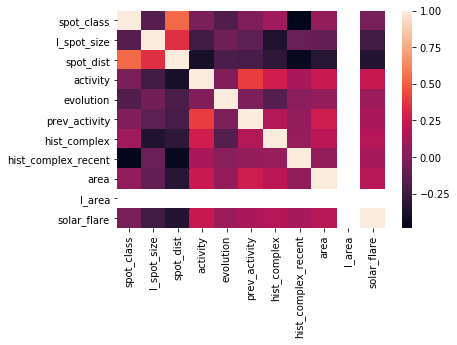

In [7]:
#check out correlations
sns.heatmap(sfdf.corr())

In [8]:
#looks like largest area of sunspot always ==1, so no info here
print len(sfdf.index), sum(sfdf.l_area==1)
sfdf.drop('l_area', inplace=True, axis=1)

1066 1066


# Plot the distributions of the different variables for the case of solar flare/ no solar flare

spot_class: Classification for configuration of group of sunspots
Flare: more often for more complex config of spots. NoFlare: more often for less complex, except H
{0: 'B', 1: 'C', 2: 'D', 3: 'E', 4: 'F', 5: 'H'}


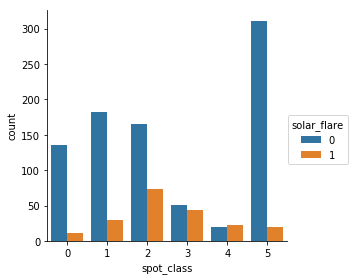

l_spot_size: Classification for the largest sunspot in the group
Flare: more often for larger spot, more often than no flare for K. NoFlare: more often for smaller spots
{0: 'A', 1: 'H', 2: 'K', 3: 'R', 4: 'S', 5: 'X'}


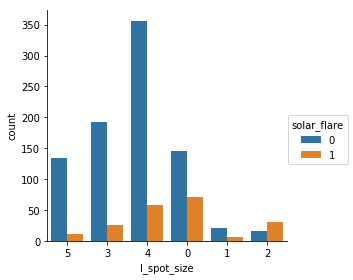

spot_dist: Classification for the distribution of the sunspots
Flare: more often for more complex dist of spots. NoFlare: much more often for simpler dist of spots
{0: 'C', 1: 'I', 2: 'O', 3: 'X'}


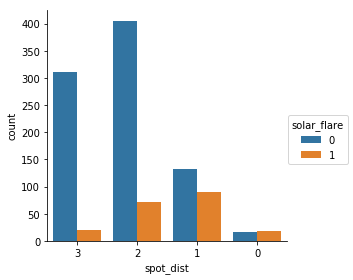

In [26]:
#get column names to visualize
variables = sfdf.columns.tolist()[:-1] #don't include target variable

#descriptions for printing alongside each plot, to give context to the visualization
descriptions = [
    'spot_class: Classification for configuration of group of sunspots',
    'l_spot_size: Classification for the largest sunspot in the group',
    'spot_dist: Classification for the distribution of the sunspots'
]

#my observations from the plots
observations = [
    'Flare: more often for more complex config of spots. NoFlare: more often for less complex, except H',
    'Flare: more often for larger spot, more often than no flare for K. NoFlare: more often for smaller spots',
    'Flare: more often for more complex dist of spots. NoFlare: much more often for simpler dist of spots'
]

#ordering for the factor plot from least to most complex
plotorder = [[0,1,2,3,4,5],
             [5,3,4,0,1,2],
             [3,2,1,0]]

for ii,vv in enumerate(variables[:3]):
    print(descriptions[ii])
    print(observations[ii])
    print(encodedict[vv])
    sns.factorplot(x=vv, hue='solar_flare', kind='count', data=sfdf, order=plotorder[ii])
    plt.show()

activity: How has the sunspot activity changed? (1/reduced, 2/unchanged)
Reduced activity makes no flare more likely


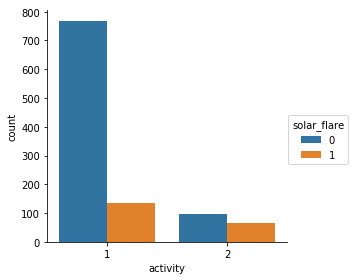

evolution: How have the sunspots evolved? (1/decay, 2/no growth, 3/growth)
Decayed evolution makes flares less likely


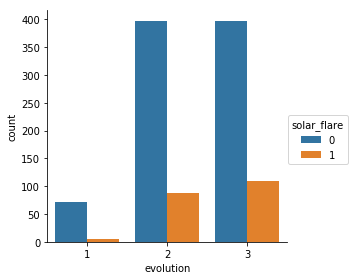

prev_activity: Were there any large flares in the last 24 hours? (1 = nothing as big an an M1, 2 = one M1, 3 = more than one M1)
Flares larger than M1 rarely happen, more M1 flares makes it more likely to have another flare


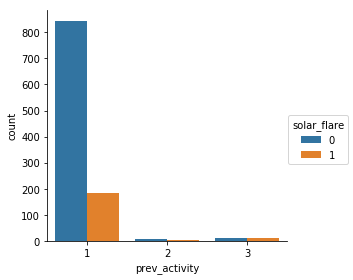

hist_complex: Has this region been complex? (1/yes, 2/no)
Flares are equally divided


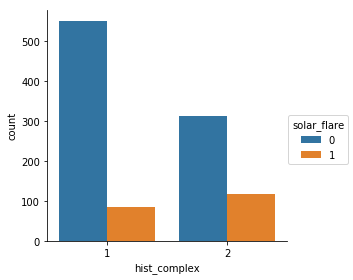

hist_complex_recent: Did this region become complex on this pass across sun's disk? (1/yes, 2/no)
If the region has been complex for a while, more likely to have flare


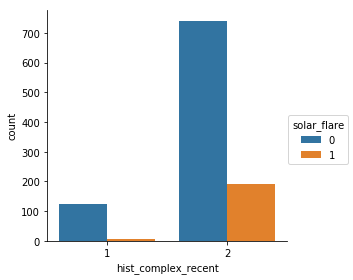

area: Area of sunspots (1/small, 2/large)
Larger sunspot makes it relatively more likely to have a flare


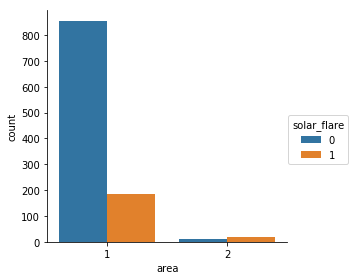

In [29]:
#descriptions for printing alongside each plot, to give context to the visualization
descriptions = [
    'activity: How has the sunspot activity changed? (1/reduced, 2/unchanged)',
    'evolution: How have the sunspots evolved? (1/decay, 2/no growth, 3/growth)',
    'prev_activity: Were there any large flares in the last 24 hours? (1 = nothing as big an an M1, 2 = one M1, 3 = more than one M1)',
    'hist_complex: Has this region been complex? (1/yes, 2/no)',
    'hist_complex_recent: Did this region become complex on this pass across sun\'s disk? (1/yes, 2/no)',
    'area: Area of sunspots (1/small, 2/large)',
    'l_area: Area of largest spot (1 means <=5, 2 means >5)' 
]

observations = [
    'Reduced activity makes no flare more likely',
    'Decayed evolution makes flares less likely',
    'Flares larger than M1 rarely happen, more M1 flares makes it more likely to have another flare',
    'Flares are equally divided',
    'If the region has been complex for a while, more likely to have flare',
    'Larger sunspot makes it relatively more likely to have a flare'
]

for ii,vv in enumerate(variables[3:]):
    print(descriptions[ii])
    print(observations[ii])
    sns.factorplot(x=vv,hue='solar_flare',kind='count',data=sfdf)
    plt.show()

### This is a bunch of categorical data that needs to be reformatted into a way the classifier can understand, so replace the classes via one hot encoding

In [11]:
#replace categorical features with dummy features, if ordered though leave as numbers
sfdf_clean = sfdf.copy()
labels = ['sc','lss','sd','act','ev','pact','hc','hcr','a']

#replace all categories w/ dummies
for ii,vv in enumerate(variables):
    #get dummmy features
    dummydf = pd.get_dummies(sfdf[vv],drop_first=True,prefix=labels[ii]).astype(int)
    #add dummy features to df
    sfdf_clean = pd.concat([sfdf_clean,dummydf],axis=1)
    #drop old feature
    sfdf_clean.drop(vv,inplace=True,axis=1)

sfdf_clean.head()

,solar_flare,sc_1,sc_2,sc_3,sc_4,sc_5,lss_1,lss_2,lss_3,lss_4,...,sd_2,sd_3,act_2,ev_2,ev_3,pact_2,pact_3,hc_2,hcr_2,a_2
0,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0
2,0,1,0,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,1,0,0,1,0,...,0,1,0,1,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0


# Now start training classifier
## Get training/test sets


In [12]:
cols = sfdf_clean.columns[sfdf_clean.columns!='solar_flare'] #input variables
X = sfdf_clean[cols]
y = sfdf_clean.solar_flare
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)
len(X_train),len(X_test)

(799, 267)

## Fit and Evaluate Logistic Regression classifier

confusion matrix
[[215   9]
 [ 31  12]]
('accuracy w/ train and test data =', 0.8247809762202754, 0.850187265917603)
classification report
             precision    recall  f1-score   support

          0       0.87      0.96      0.91       224
          1       0.57      0.28      0.37        43

avg / total       0.83      0.85      0.83       267



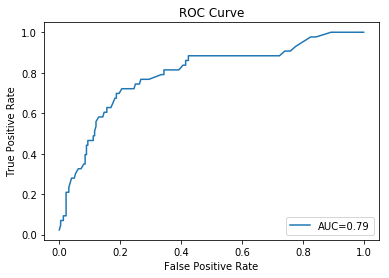

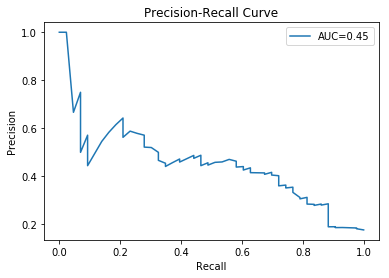

In [13]:
#train model
logreg = LogisticRegression(random_state=0)
logreg.fit(X_train,y_train)

#evaluate model

#predictions
y_pred_logreg = logreg.predict(X_test)
prob_logreg = logreg.predict_proba(X_test)[:,1]

#confusion matrix
cm_logreg = metrics.confusion_matrix(y_test, y_pred_logreg)
print ('confusion matrix')
print(cm_logreg)

#accuracy and classification report
print( 'accuracy w/ train and test data =', logreg.score(X_train,y_train), logreg.score(X_test,y_test)) #doesn't mean much because of imbalanced classes
print('classification report')
print(metrics.classification_report(y_test,y_pred_logreg))
#precision == how many correctly predicted flares/ how many total flares were predicted
#recall == how many correctly predicted flares/ how many flares there really were

#roc curve
fpr_logreg, tpr_logreg, _ = metrics.roc_curve(y_test,prob_logreg)
auc_logreg = metrics.roc_auc_score(y_test,prob_logreg)
figure()
title('ROC Curve')
plot(fpr_logreg,tpr_logreg,label='AUC=%0.2f' %auc_logreg)
xlabel('False Positive Rate')
ylabel('True Positive Rate')
legend(loc=4)

#precision-recall curve
prec_logreg, rc_logreg, _ = metrics.precision_recall_curve(y_test,prob_logreg)
pr_auc = metrics.auc(rc_logreg,prec_logreg)
figure()
title('Precision-Recall Curve')
plot(rc_logreg,prec_logreg,label='AUC=%0.2f' %pr_auc)
xlabel('Recall')
ylabel('Precision')
legend()

### Looks like the spot class/largest spot class has a large impact

In [14]:
#examine coefficients
coef = array(zip(cols, logreg.coef_[0]))
coef=coef[argsort(coef[:,1])][::-1]
coef

array([['lss_2', '0.7089172135674808'],
       ['sc_3', '0.6035237803720556'],
       ['sc_4', '0.5895328426899936'],
       ['act_2', '0.481173590403271'],
       ['sc_2', '0.35932881359450225'],
       ['ev_3', '0.3292834089171255'],
       ['pact_2', '0.15097544972366653'],
       ['ev_2', '0.09065248077793896'],
       ['pact_3', '0.07745681259493424'],
       ['lss_5', '-0.9837481791052812'],
       ['sc_5', '-0.8345728323153337'],
       ['sd_3', '-0.8345728323153337'],
       ['sd_2', '-0.5923954591832623'],
       ['lss_3', '-0.548366575741374'],
       ['lss_4', '-0.3609014834090571'],
       ['a_2', '-0.26291909315425954'],
       ['sc_1', '-0.198677274791391'],
       ['sd_1', '-0.18043772148008394'],
       ['hc_2', '-0.09769790264867996'],
       ['hcr_2', '-0.07281053099620116'],
       ['lss_1', '-0.04322000096185811']], dtype='|S20')

# Takeaways
# * The complexity of the configurations of the spots, and recent activity appear to be most important in predicting another flare
# * Looks like I need to look into more methods for dealing with imbalanced classes


# Tests

### Look at accuracy of classifying everything as no flare

In [15]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
ydpred = dummy.predict(X_test)
print metrics.accuracy_score(y_test, ydpred)

0.8389513108614233


### Try gridsearch over logistic regression hyperparameters

In [16]:
from sklearn.model_selection import GridSearchCV

grid = {'C': [0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1','l2']}
score = ['precision','recall']

for ss in score:
    print('Scoring metric is %s' %ss)
    gs = GridSearchCV(LogisticRegression(), grid, cv=10, scoring=ss)
    gs.fit(X_train,y_train)

    y_pred_gs = gs.predict(X_test)
    prob_gs = gs.predict_proba(X_test)[:,1]
    
    print('Best parameters:')
    print(gs.best_estimator_)

    print('Scores')
    for params, mean_score, scores in gs.grid_scores_:
        print('%0.3f (+/-%0.03f) for %r'
            % (mean_score, scores.std() / 2, params))

    print('Classification report')
    print(metrics.classification_report(y_test, y_pred_gs))

 

Scoring metric is precision


/Users/brittanyfuzia/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Best parameters:
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Scores
0.000 (+/-0.000) for {'penalty': 'l1', 'C': 0.01}
0.000 (+/-0.000) for {'penalty': 'l2', 'C': 0.01}
0.000 (+/-0.000) for {'penalty': 'l1', 'C': 0.1}
0.571 (+/-0.148) for {'penalty': 'l2', 'C': 0.1}
0.622 (+/-0.081) for {'penalty': 'l1', 'C': 1}
0.577 (+/-0.087) for {'penalty': 'l2', 'C': 1}
0.569 (+/-0.067) for {'penalty': 'l1', 'C': 10}
0.569 (+/-0.067) for {'penalty': 'l2', 'C': 10}
0.569 (+/-0.067) for {'penalty': 'l1', 'C': 100}
0.569 (+/-0.067) for {'penalty': 'l2', 'C': 100}
0.569 (+/-0.067) for {'penalty': 'l1', 'C': 1000}
0.569 (+/-0.067) for {'penalty': 'l2', 'C': 1000}
Classification report
             precision    recall  f1-score   support

          0       0.87      0.96      0.91       22

/Users/brittanyfuzia/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Best parameters:
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Scores
0.000 (+/-0.000) for {'penalty': 'l1', 'C': 0.01}
0.000 (+/-0.000) for {'penalty': 'l2', 'C': 0.01}
0.000 (+/-0.000) for {'penalty': 'l1', 'C': 0.1}
0.113 (+/-0.039) for {'penalty': 'l2', 'C': 0.1}
0.196 (+/-0.029) for {'penalty': 'l1', 'C': 1}
0.196 (+/-0.029) for {'penalty': 'l2', 'C': 1}
0.215 (+/-0.028) for {'penalty': 'l1', 'C': 10}
0.215 (+/-0.028) for {'penalty': 'l2', 'C': 10}
0.215 (+/-0.028) for {'penalty': 'l1', 'C': 100}
0.215 (+/-0.028) for {'penalty': 'l2', 'C': 100}
0.215 (+/-0.028) for {'penalty': 'l1', 'C': 1000}
0.215 (+/-0.028) for {'penalty': 'l2', 'C': 1000}
Classification report
             precision    recall  f1-score   support

          0       0.87      0.96      0.91       2

/Users/brittanyfuzia/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


### Try with random forest

confusion matrix
[[207  17]
 [ 31  12]]
('accuracy w/ train and test data =', 0.8798498122653317, 0.8202247191011236)
classification report
             precision    recall  f1-score   support

          0       0.87      0.92      0.90       224
          1       0.41      0.28      0.33        43

avg / total       0.80      0.82      0.81       267



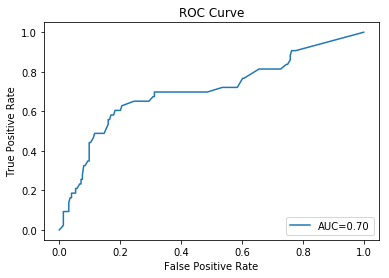

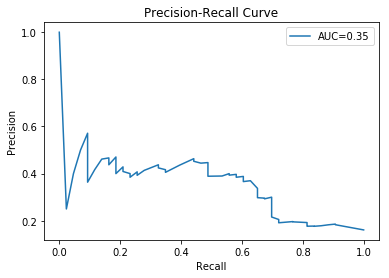

In [17]:
from sklearn.ensemble import RandomForestClassifier

#split test/train data    
cols_rf = sfdf.columns[sfdf.columns!='solar_flare'] #input variables
X_rf = sfdf[cols_rf]
y_rf = sfdf.solar_flare
X_rf_train,X_rf_test,y_rf_train,y_rf_test = train_test_split(X_rf,y_rf,random_state=0)#encode data

#train model
rf = RandomForestClassifier(random_state=0)
rf.fit(X_rf_train,y_rf_train)

#evaluate model

#predictions
y_pred_rf = rf.predict(X_rf_test)
prob_rf = rf.predict_proba(X_rf_test)[:,1]

#confusion matrix
cm_rf = metrics.confusion_matrix(y_rf_test, y_pred_rf)
print ('confusion matrix')
print(cm_rf)

#accuracy and classification report
print( 'accuracy w/ train and test data =', rf.score(X_rf_train,y_rf_train), rf.score(X_rf_test,y_rf_test)) #doesn't mean much because of imbalanced classes
print('classification report')
print(metrics.classification_report(y_rf_test,y_pred_rf))
#precision == how many correctly predicted flares/ how many total flares were predicted
#recall == how many correctly predicted flares/ how many flares there really were

#roc curve
fpr_rf, tpr_rf, _ = metrics.roc_curve(y_rf_test,prob_rf)
auc_rf = metrics.roc_auc_score(y_rf_test,prob_rf)
figure()
title('ROC Curve')
plot(fpr_rf,tpr_rf,label='AUC=%0.2f' %auc_rf)
xlabel('False Positive Rate')
ylabel('True Positive Rate')
legend(loc=4)

#precision-recall curve
prec_rf, rc_rf, _ = metrics.precision_recall_curve(y_rf_test,prob_rf)
pr_auc = metrics.auc(rc_rf,prec_rf)
figure()
title('Precision-Recall Curve')
plot(rc_rf,prec_rf,label='AUC=%0.2f' %pr_auc)
xlabel('Recall')
ylabel('Precision')
legend()

### It looks again like the complexity of the configurations of spots are most important

In [18]:
#how important is each feature
fi = array(zip(sfdf[cols_rf], rf.feature_importances_))
fi=fi[argsort(fi[:,1])][::-1]
fi

array([['spot_class', '0.256273853444002'],
       ['l_spot_size', '0.21925234241071587'],
       ['spot_dist', '0.17114740904731185'],
       ['evolution', '0.12696520794470023'],
       ['hist_complex', '0.07097579095320788'],
       ['activity', '0.06096122562896612'],
       ['prev_activity', '0.05905058364928262'],
       ['area', '0.02561966479985613'],
       ['hist_complex_recent', '0.009753922121957349']], dtype='|S20')

# Random Tests

In [19]:
#grid search plots
#roc curve
    fpr_gs, tpr_gs, _ = metrics.roc_curve(y_test,prob_gs)
    auc_gs = metrics.roc_auc_score(y_test,prob_gs)
    figure()
    title('ROC Curve')
    plot(fpr_gs,tpr_gs,label='AUC=%0.2f' %auc_gs)
    xlabel('False Positive Rate')
    ylabel('True Positive Rate')
    legend(loc=4)
    plt.show()

    #precision-recall curve
    prec_gs, rc_gs, _ = metrics.precision_recall_curve(y_test,prob_gs)
    pr_auc = metrics.auc(rc_gs,prec_gs)
    figure()
    title('Precision-Recall Curve')
    plot(rc_gs,prec_gs,label='AUC=%0.2f' %pr_auc)
    xlabel('Recall')
    ylabel('Precision')
    legend()
    plt.show()

IndentationError: unexpected indent (<ipython-input-19-26637c4f75ec>, line 3)

In [20]:
for cc in [1,3,5,7,10]:
    lr = LogisticRegression(C=cc,random_state=0,penalty='l1')
    lr.fit(X_train,y_train)
    y_pred_lr = lr.predict(X_test)
    print(metrics.classification_report(y_test,y_pred_lr))

             precision    recall  f1-score   support

          0       0.87      0.96      0.91       224
          1       0.55      0.28      0.37        43

avg / total       0.82      0.85      0.83       267

             precision    recall  f1-score   support

          0       0.87      0.95      0.91       224
          1       0.52      0.28      0.36        43

avg / total       0.82      0.84      0.82       267

             precision    recall  f1-score   support

          0       0.87      0.96      0.91       224
          1       0.55      0.28      0.37        43

avg / total       0.82      0.85      0.83       267

             precision    recall  f1-score   support

          0       0.87      0.96      0.91       224
          1       0.55      0.26      0.35        43

avg / total       0.82      0.85      0.82       267

             precision    recall  f1-score   support

          0       0.87      0.96      0.91       224
          1       0.55      0.26 

classification report
             precision    recall  f1-score   support

          0       0.84      1.00      0.91       224
          1       0.00      0.00      0.00        43

avg / total       0.70      0.84      0.77       267



/Users/brittanyfuzia/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


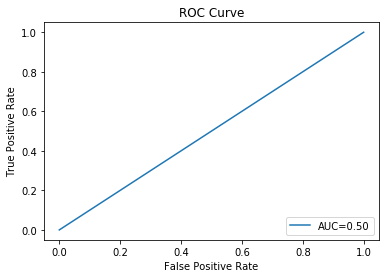

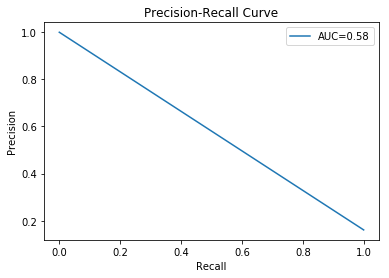

In [23]:
#evaluation of dummy model
print('classification report')
print(metrics.classification_report(y_test,ydpred))

dprob = dummy.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,dprob)
auc = metrics.roc_auc_score(y_test,dprob)
figure()
title('ROC Curve')
plot(fpr,tpr,label='AUC=%0.2f' %auc)
xlabel('False Positive Rate')
ylabel('True Positive Rate')
legend(loc=4)

#precision-recall curve
prec, rc, _ = metrics.precision_recall_curve(y_test,dprob)
auc = metrics.auc(rc,prec)
figure()
title('Precision-Recall Curve')
plot(rc,prec,label='AUC=%0.2f' %auc)
xlabel('Recall')
ylabel('Precision')
legend()